In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

## Testovaci ucelove funkce

In [120]:
def sphere(x: list) -> float:
    x = np.array(x)
    return np.sum(x**2)


def rastrigin(x: list) -> float:
    x = np.array(x)
    d = x.shape[0]
    return 10 * d + np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x))


def ackley(x: list) -> float:
    x = np.array(x)
    d = x.shape[0]
    sum_sq = np.sum(x**2)
    sum_cos = np.sum(np.cos(2 * np.pi * x))
    return -20 * np.exp(-0.2 * np.sqrt(sum_sq/d)) - np.exp(sum_cos/d) + 20 + np.exp(1)

## LS, HC, SA

In [98]:
def shc(function,
        dim: int, x_min: float, x_max: float,
        max_iter: int,
        neighbor_size: float,
        num_neighbors: int) -> tuple([list, float, np.array]):
    """
    Implementace Stochastic Hill Climber

    Paramtery:
        function      - testovaci ucelova funkce
        dim           - velikost dimenze (pocet paramteru funkce)
        x_min         - minimalni hodnota parametru
        x_max         - maximalni hodnota parametru
        max_iter - maximali pocet iteraci
        neighbor_size - velikost sousedstvi
        num_neighbors - pocet sousedu
    """
    # historie
    history = []

    # nahodna inicializace
    x_best = np.random.uniform(x_min, x_max, dim)
    y_best = function(x_best)
    history.append(y_best)

    # Iterativní vylepšování řešení
    for _ in range(max_iter):
        # vygeneruje nahodneho souseda
        x_new = x_best + np.random.normal(0, neighbor_size, dim)
        x_new = np.clip(x_new, x_min, x_max)
        y_new = function(x_new)

        # pokud je reseni lepsi zaznamena si ho jako nejlepsi reseni
        if y_new < y_best:
            x_best = x_new
            y_best = y_new

        # zaznamenani nejlepsi hodnoty do historie
        history.append(y_best)

    return tuple([x_best, y_best, history])


def ls(function,
       dim: int, x_min: float, x_max: float,
       max_iter: int,
       neighbor_size: float,
       num_neighbors: int) -> tuple([list, float, np.array]):
    """
    Implementace Local Search

    Paramtery:
        function      - testovaci ucelova funkce
        dim           - velikost dimenze (pocet paramteru funkce)
        x_min         - minimalni hodnota parametru
        x_max         - maximalni hodnota parametru
        max_iter - maximali pocet iteraci
        neighbor_size - velikost sousedstvi
        num_neighbors - pocet sousedu
    """
    # historie
    history = []

    # nahodna inicializace
    x_best = np.random.uniform(x_min, x_max, dim)
    y_best = function(x_best)
    history.append(y_best)

    # iterace => hledani lepsiho reseni
    for _ in range(max_iter):
        # vygenerovani nahodnych sousedu
        neighbors = x_best + \
            np.random.normal(0, neighbor_size, size=(num_neighbors, dim))
        neighbors = np.clip(neighbors, x_min, x_max)
        ys = [function(x) for x in neighbors]

        # nejde nejlepsiho souseda
        idx_best = np.argmin(ys)
        y_new = ys[idx_best]
        x_new = neighbors[idx_best]

        # pokud je reseni lepsi zaznamena si ho jako nejlepsi reseni
        if y_new < y_best:
            x_best = x_new
            y_best = y_new

        # zaznamenani nejlepsi hodnoty do historie
        history.append(y_best)

    return tuple([x_best, y_best, history])


def sa(function,
       dim: int, x_min: float, x_max: float,
       max_iter: int, neighbor_size: float,
       T0: float, Tf: float) -> tuple([list, float, np.array]):
    """
    Simulovane zihani

    Parametry:
        function - testovaci ucelova funkce
        dim - velikost dimenze (pocet paramteru funkce)
        x_min - minimalni hodnota parametru
        x_max - maximalni hodnota parametru
        neighbor_size - velikost sousedstvi
        max_iter - maximalni pocet iteraci
        T0 - pocatecni teplota
        Tf - koncova teplota (mensi teplota)
    """
    # historie
    history = []

    # nahodna inicializace
    x_best = np.random.uniform(x_min, x_max, dim)
    y_best = function(x_best)
    history.append(y_best)

    T = T0
    for i in range(max_iter):
        neighbor_x = x_best + np.random.normal(0, neighbor_size, dim)
        neighbor_x = np.clip(neighbor_x, x_min, x_max)
        neighbor_y = function(neighbor_x)
        delta = neighbor_y - y_best

        if delta <= 0:
            x_best = neighbor_x
            y_best = neighbor_y
        else:
            p = math.exp(-delta/T)
            if random.random() < p:
                x_best = neighbor_x
                y_best = neighbor_y
        T = T0 - i * (T0 - Tf) / max_iter

        # zaznamenani nejlepsi hodnoty do historie
        history.append(y_best)

    return tuple([x_best, y_best, history])


## Vypocet statistiky

In [1]:
def statistics(iters: int, callback):
    min_value = float('inf')
    max_value = float('-inf')
    mean_value = 0.0
    median_value = 0.0
    std_value = 0.0
    list_y = []
    mean_history = []

    for i in range(iters):
        _, y_best, history = callback()
        min_value = np.min([min_value, y_best])
        max_value = np.max([min_value, y_best])
        list_y.append(y_best)
        if len(mean_history) == 0:
            mean_history = history
        else:
            for i, value in enumerate(history):
                mean_history[i] += value

    mean_value = np.mean(list_y)
    median_value = np.median(list_y)
    std_value = np.std(list_y)
    for i, _ in enumerate(mean_history):
        mean_history[i] = mean_history[i] / iters

    return tuple([min_value, max_value, mean_value, median_value, std_value, mean_history])

In [107]:
def plot(log: bool, title: str, history_sa: np.array, history_ls: np.array, history_hc: np.array):
    x = range(len(history_sa))

    plt.plot(x, history_sa, label="SA")
    plt.plot(x, history_ls, label="LS")
    plt.plot(x, history_hc, label="HC")
    
    if log:
        plt.yscale('log')
    plt.xlabel("iteration")
    plt.ylabel("f(x)")
    plt.title(title)

    plt.legend()
    plt.show()

## Konfigurace

In [92]:
# pocet iteraci (statistika)
iter_stat = 30
# pocet iteraci optimalizacniho algoritmu
iter = 1000
# dimenze
dim = 5
# T0
T0 = 100
# Tf
Tf = 0

## Sphere

<--HC--------------------------->
Minimum:  0.006403700286793579
Maximum:  0.018924955653928988
Mean:  0.021323861374409527
Median:  0.020817361480660206
STD:  0.008547239548414381
<--LS--------------------------->
Minimum:  0.0010167465215408923
Maximum:  0.004713270681621389
Mean:  0.007433890975702157
Median:  0.007748774686890602
STD:  0.003108131174440348
<--SA--------------------------->
Minimum:  0.3481928662784885
Maximum:  32.363400508505855
Mean:  8.983552391810028
Median:  5.62630185717264
STD:  8.740990298177842


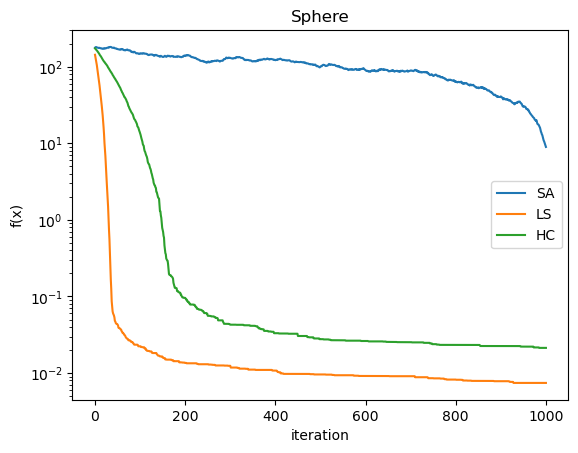

In [108]:
min_value, max_value, mean_value, median_value, std_value, history_hc = statistics(iter_stat, lambda: shc(sphere, dim, -10, 10, iter, 0.3, 10))
print("<--HC--------------------------->")
print("Minimum: ", min_value)
print("Maximum: ", max_value)
print("Mean: ", mean_value)
print("Median: ", median_value)
print("STD: ", std_value)

min_value, max_value, mean_value, median_value, std_value, history_ls = statistics(iter_stat, lambda: ls(sphere, dim, -10, 10, iter, 0.3, 10))
print("<--LS--------------------------->")
print("Minimum: ", min_value)
print("Maximum: ", max_value)
print("Mean: ", mean_value)
print("Median: ", median_value)
print("STD: ", std_value)

min_value, max_value, mean_value, median_value, std_value, history_sa = statistics(iter_stat, lambda: sa(sphere, dim, -10, 10, iter, 0.3, T0, Tf))
print("<--SA--------------------------->")
print("Minimum: ", min_value)
print("Maximum: ", max_value)
print("Mean: ", mean_value)
print("Median: ", median_value)
print("STD: ", std_value)


plot(True, "Sphere", history_sa, history_ls, history_hc)

## Rastrigin

<--HC--------------------------->
Minimum:  45.98700997732685
Maximum:  92.70474067477156
Mean:  98.42993905299707
Median:  92.6507593267908
STD:  45.11908221956281
<--LS--------------------------->
Minimum:  5.900605518427469
Maximum:  13.971538683443164
Mean:  18.00510095477837
Median:  15.924561400762308
STD:  9.064639152016433
<--SA--------------------------->
Minimum:  32.96497046785748
Maximum:  54.83722812366688
Mean:  104.00450289260738
Median:  81.23225833594418
STD:  84.72459882095015


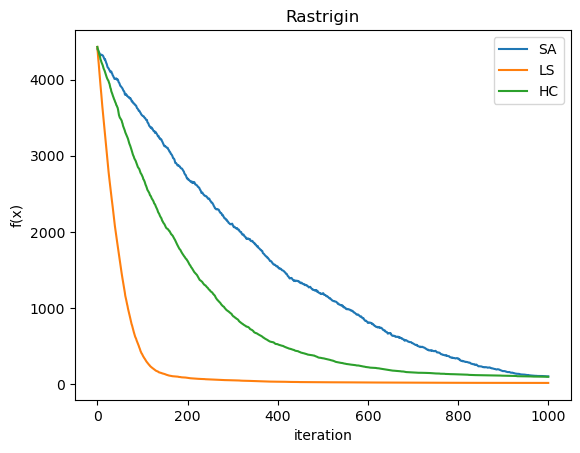

In [113]:
min_value, max_value, mean_value, median_value, std_value, history_hc = statistics(iter_stat, lambda: shc(rastrigin, dim, -50, 50, iter, 0.4, 10))
print("<--HC--------------------------->")
print("Minimum: ", min_value)
print("Maximum: ", max_value)
print("Mean: ", mean_value)
print("Median: ", median_value)
print("STD: ", std_value)

min_value, max_value, mean_value, median_value, std_value, history_ls = statistics(iter_stat, lambda: ls(rastrigin, dim, -50, 50, iter, 0.4, 10))
print("<--LS--------------------------->")
print("Minimum: ", min_value)
print("Maximum: ", max_value)
print("Mean: ", mean_value)
print("Median: ", median_value)
print("STD: ", std_value)

min_value, max_value, mean_value, median_value, std_value, history_sa = statistics(iter_stat, lambda: sa(rastrigin, dim, -50, 50, iter, 0.4, T0, Tf))
print("<--SA--------------------------->")
print("Minimum: ", min_value)
print("Maximum: ", max_value)
print("Mean: ", mean_value)
print("Median: ", median_value)
print("STD: ", std_value)


plot(False, "Rastrigin", history_sa, history_ls, history_hc)

## Ackley

<--HC--------------------------->
Minimum:  0.4379485721139216
Maximum:  2.2326176246704823
Mean:  1.9215855366433985
Median:  1.9855863582245488
STD:  0.5206907252666865
<--LS--------------------------->
Minimum:  0.5113770244663169
Maximum:  1.0276652110193862
Mean:  1.1428554539341882
Median:  1.1698928662754278
STD:  0.29424279851683377
<--SA--------------------------->
Minimum:  3.647747207917462
Maximum:  8.819931845077333
Mean:  12.407821765009137
Median:  12.72358268863196
STD:  2.932285021544839


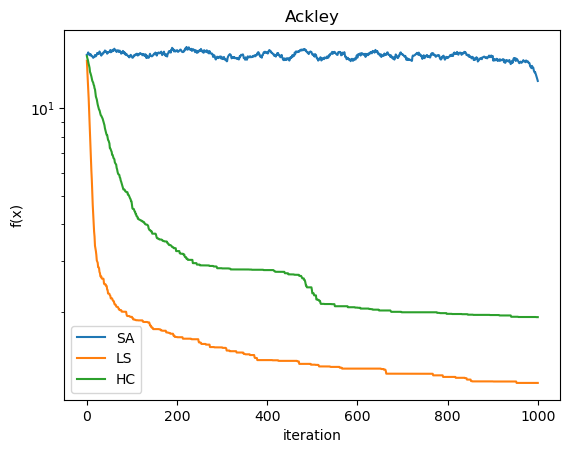

In [121]:
min_value, max_value, mean_value, median_value, std_value, history_hc = statistics(iter_stat, lambda: shc(ackley, dim, -10, 10, iter, 1, 10))
print("<--HC--------------------------->")
print("Minimum: ", min_value)
print("Maximum: ", max_value)
print("Mean: ", mean_value)
print("Median: ", median_value)
print("STD: ", std_value)

min_value, max_value, mean_value, median_value, std_value, history_ls = statistics(iter_stat, lambda: ls(ackley, dim, -10, 10, iter, 1, 10))
print("<--LS--------------------------->")
print("Minimum: ", min_value)
print("Maximum: ", max_value)
print("Mean: ", mean_value)
print("Median: ", median_value)
print("STD: ", std_value)

min_value, max_value, mean_value, median_value, std_value, history_sa = statistics(iter_stat, lambda: sa(ackley, dim, -10, 10, iter, 1, T0, Tf))
print("<--SA--------------------------->")
print("Minimum: ", min_value)
print("Maximum: ", max_value)
print("Mean: ", mean_value)
print("Median: ", median_value)
print("STD: ", std_value)


plot(True, "Ackley", history_sa, history_ls, history_hc)